# Create Quantile Forecasts
In this notebook, the prosumption quantile forecasts are created. Each hour of each day is forecasted separately with 100 quantile forecasts ranging from 1% to 99% in equidistant increments.

The following dataset is used: <br>
**Dataset**: [Open Power System Data. 2020 Data Package Household Data Version 2020-04-15]  
**License**: This data is licensed under CC-BY.  
**Accessed from**: [[OPSD Platform](https://data.open-power-system-data.org/household_data/2020-04-15/)]

## Data Read-In & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple
from datetime import datetime
import os

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.data import MixedCovariatesTrainingDataset
from darts.explainability.tft_explainer import TFTExplainer
from darts.models import TFTModel

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [2]:
data = pd.read_csv('https://data.open-power-system-data.org/household_data/2020-04-15/household_data_60min_singleindex.csv', date_format='%Y-%m-%dT%H:%M:%SZ', index_col = "utc_timestamp", parse_dates=True , sep=',')
data.index = pd.to_datetime(data.index)

# parse time stamp from utc to local time utc to cest
data.index = data.index + pd.Timedelta(hours=2)

# rename index to cest_timestamp
data.index.name = 'cest_timestamp'
valid_buildings = ['residential4']

def get_building_prosumption_data(data, building):
    prosumption = data[f"DE_KN_{building}_grid_import"].diff(1) - data[f"DE_KN_{building}_grid_export"].diff(1)
    return prosumption.asfreq('1h').dropna()

data_selected_buildings_prosumption = [(building, get_building_prosumption_data(data, building)) for building in valid_buildings ]

In [3]:
os.makedirs('../data/ground_truth', exist_ok=True)
for building, prosumption in data_selected_buildings_prosumption:
    prosumption.to_csv(f"../data/ground_truth/{building}_prosumption.csv")

## Create Forecasts

In [4]:
class MixedCovariates6AMTrainingDataset(MixedCovariatesTrainingDataset):
    """
    Custom Dataset only contain 6 a.m. data

    # currtenly only support 
    past_target, past_covariates, historic_future_covariates, future_covariates, future_target

    not support sample_weight and static_covariates
    
    """
    def __init__(self, series: TimeSeries, past_covariates: Optional[TimeSeries], 
                 historic_future_covariates: Optional[TimeSeries], 
                 future_covariates: Optional[TimeSeries], 
                 static_covariates: Optional[np.ndarray], input_chunk_length: int, 
                 output_chunk_length: int):
        super().__init__()
        self.series = series
        self.past_covariates = past_covariates
        self.historic_future_covariates = historic_future_covariates
        self.future_covariates = future_covariates
        self.static_covariates = static_covariates
        self.input_chunk_length = input_chunk_length
        self.output_chunk_length = output_chunk_length
        
        # Identify valid indices for 6 a.m. data
        self.valid_indices = np.where(self.series.time_index.hour == 6)[0]
        # Filter valid indices to ensure we have enough data for output chunks
        self.valid_indices = self.valid_indices[self.valid_indices >= self.input_chunk_length]

    def __len__(self) -> int:
        return len(self.valid_indices)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], np.ndarray]:
        actual_index = self.valid_indices[idx]
        
        start_past_index = max(0, actual_index - self.input_chunk_length)
        
        # Get the past and future targets using the actual index
        past_target = self.series.values()[start_past_index: actual_index]
        future_target = self.series.values()[actual_index: actual_index + self.output_chunk_length]

        # Use None for any optional covariates if they are not present
        past_covariates = (self.past_covariates.values()[start_past_index: actual_index] 
                           if self.past_covariates is not None else None)
        historic_future_covariates = (self.historic_future_covariates.values()[start_past_index: actual_index] 
                                       if self.historic_future_covariates is not None else None)
        future_covariates = (self.future_covariates.values()[actual_index: actual_index + self.output_chunk_length]
                             if self.future_covariates is not None else None)

        # Use None for static covariates and sample weight
        return (past_target, past_covariates, historic_future_covariates, future_covariates, None, None, future_target)
    
    """ equivalent to sequential_dataset class darts    
    (
            past_target,
            past_covariate,
            historic_future_covariate,
            future_covariate,
            static_covariate,
            sample_weight,
            future_target,
        )
    
    """

In [5]:
train_split = 365*24 - 1
validation_split = 90 * 24

for building, prosumption in data_selected_buildings_prosumption:
    # make data starting with the first 00:00 Timestamp
    first_prosumption_index = prosumption[prosumption.index.hour == 6]
    prosumption = prosumption[first_prosumption_index.index[0]:]

    # get the timestamp after train split
    training_cutoff = prosumption.index[train_split]
    training_cutoff = pd.Timestamp(training_cutoff)

    validation_cutoff = prosumption.index[train_split + validation_split]

    # generate the time series
    prosumption_series = TimeSeries.from_series(prosumption)
    prosumption_series.astype(np.float32)

    train, test = prosumption_series.split_after(training_cutoff)
    val, test = test.split_after(validation_cutoff)

    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    test_transformed = transformer.transform(test)
    val_transformed = transformer.transform(val)
    series_transformed = transformer.transform(prosumption_series)


    covariates = datetime_attribute_timeseries(prosumption_series, attribute="year", one_hot=False)
    covariates = covariates.stack(
        datetime_attribute_timeseries(prosumption_series, attribute="month", one_hot=False)
    )
    covariates = covariates.stack(
        datetime_attribute_timeseries(prosumption_series, attribute="weekday", one_hot=False)
    )
    covariates = covariates.stack(
        datetime_attribute_timeseries(prosumption_series, attribute="hour", one_hot=False)
    )

    covariates = covariates.astype(np.float32)
    scaler_covs = Scaler()
    cov_train, cov_val = covariates.split_after(training_cutoff)
    scaler_covs.fit(cov_train)
    covariates_transformed = scaler_covs.transform(covariates)


    # stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
    # a period of 5 epochs (`patience`)
    my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=15,
        min_delta=0.05,
        mode='min', 
        verbose=False,
    )

    # instaniate the MixedCovariates6AMTrainingDataset
    dataset_train = MixedCovariates6AMTrainingDataset(
        series=train_transformed,
        past_covariates=covariates_transformed,
        historic_future_covariates=covariates_transformed,
        future_covariates=covariates_transformed,
        static_covariates=None,
        input_chunk_length=168,
        output_chunk_length=24
    )

    dataset_val = MixedCovariates6AMTrainingDataset(
        series=val_transformed,
        past_covariates=covariates_transformed,
        historic_future_covariates=covariates_transformed,
        future_covariates=covariates_transformed,
        static_covariates=None,
        input_chunk_length=168,
        output_chunk_length=24
    )
    pl_trainer_kwargs={"callbacks": [my_stopper]}


    # default quantiles for QuantileRegression
    quantiles = [np.round(i,2) for i in np.arange(0.01, 1, 0.01)]
    input_chunk_length = 168
    forecast_horizon = 24
    tft = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=forecast_horizon,
        hidden_size=16,
        batch_size=8,
        n_epochs=1000,
        likelihood=QuantileRegression(
            quantiles=quantiles
        ),
        random_state=42,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs
    )


    tft.fit_from_dataset(dataset_train, val_dataset=dataset_val, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_cova

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [6]:
tft = TFTModel.load_from_checkpoint(tft.model_name, best=True)

/home/ws/hp5743/miniconda3/envs/forecasts_opsd_households/lib/python3.12/site-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

In [7]:
num_samples = 100
backtest_series = tft.historical_forecasts(
    series_transformed,
    future_covariates = covariates_transformed,
    past_covariates = covariates_transformed,
    start=test.start_time(),
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
    num_samples=num_samples
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
# save the forecast to csv
transformer.inverse_transform(concatenate(backtest_series)).quantiles_df(quantiles).to_csv(f"../data/quantile_forecasts/{building}_model_{tft.model_name}.csv")

In [9]:
# display the start
print(f"Training Start: {prosumption_series.start_time()}")

# display the time series cutoffs
print(f"Training cutoff: {training_cutoff}")

print(f"Validation Start: {val.start_time()}")
print(f"Validation cutoff: {validation_cutoff}")

print(f"Test Start: {test.start_time()}")
print(f"Test End: {test.end_time()}")

# display the end
print(f"End: {prosumption_series.end_time()}")

Training Start: 2015-10-11 06:00:00
Training cutoff: 2016-10-10 05:00:00
Validation Start: 2016-10-10 06:00:00
Validation cutoff: 2017-01-08 05:00:00
Test Start: 2017-01-08 06:00:00
Test End: 2018-02-05 01:00:00
End: 2018-02-05 01:00:00


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

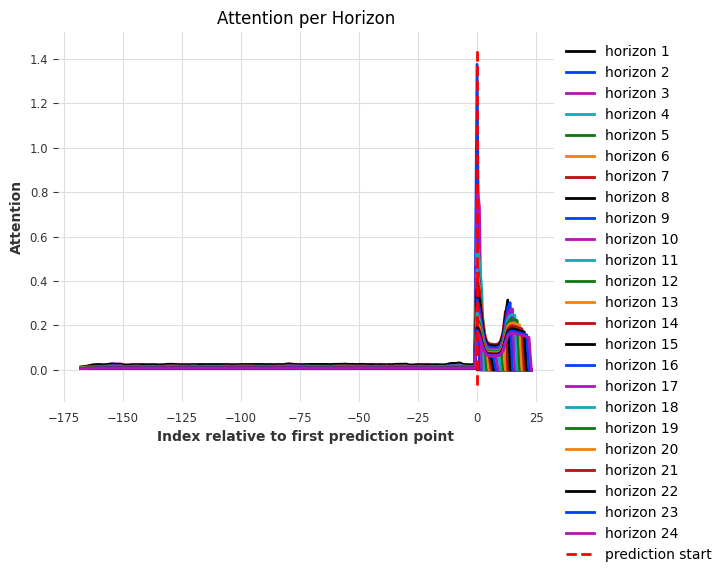

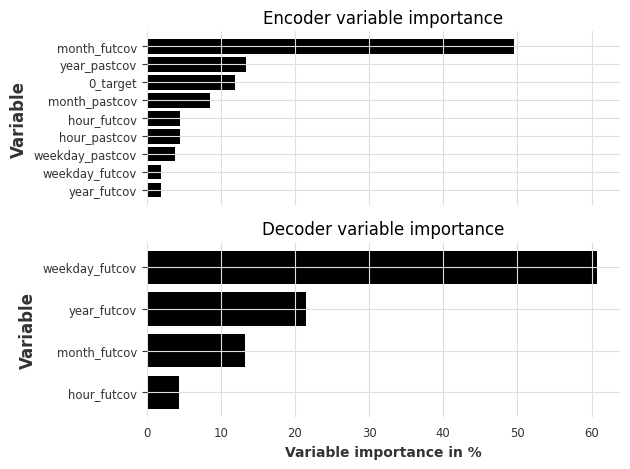

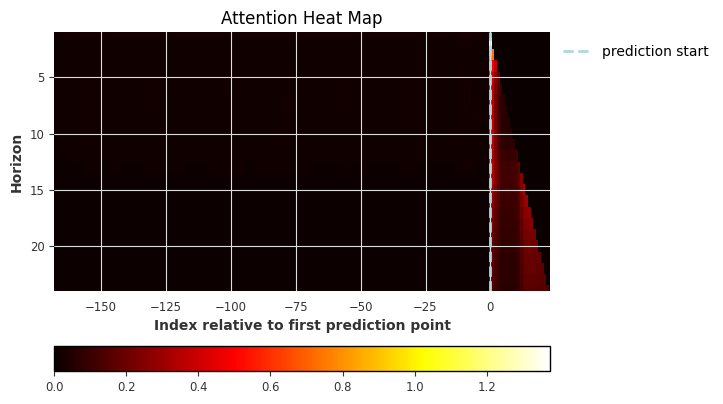

<Axes: title={'center': 'Attention Heat Map'}, xlabel='Index relative to first prediction point', ylabel='Horizon'>

In [10]:
# create the explainer and generate explanations
explainer = TFTExplainer(tft, background_series=series_transformed[:-100], background_future_covariates=covariates_transformed, background_past_covariates=covariates_transformed)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

explainer.plot_attention(results, plot_type="heatmap")